# Movies Recommender 🍿 - Building a Recommendation System
A project proposal by **Adi Benziony (ID 313364549)**

## Introduction and Motivation
The film industry is a giant business, and every year thousands of new movies are made. In 2019 alone 4,693 new movies were released ([source](https://www.the-numbers.com/movies/production-countries#tab=year)).  
With all those new movies released each year it can be confusing to choose which movies to see, and that's where a personalized recommendation system can come in handy.

The growth in digital data volume that's at the disposal of big companies allowed a new era of personalized recommendation systems to arise.  
Every company serving consumers content wants to find a way to keep the consumer engaged and entertained, one of the ways this can be achived is by making it easier for the user to find content he will like.  
Companies like Spotify, Netflix, Twitter, Facebook and even dating apps such as Tinder all have recommendation systems to keep users on the platform.

![Netflix recommendations](resources/recommendations-banner.png)

In this notebook we will use [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) posted on Kaggle to build **a recommendation system for movies based on a user's ratings**.

## Dataset
This project is inspired by the dataset [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) posted on Kaggle, featuring movies information like title, genres, release date and more along with users' movies ratings.  
The dataset is a combination of [_MovieLens_](https://movielens.org/) and [_TMDB_](https://www.themoviedb.org/).  
MovieLens is a research site run by _GroupLens Research_ at the University of Minnesota and contains users' movies ratings, and _TMDB_ is a website containing data on millions of movies.

Our dataset cotains:
* **45,000 movies** in various languages (but mostly English) with properties like budget, revenue, genres, language, release date, duration, and ratings.
* **26 million ratings by 260,000 users**

## Dataset Loading & Cleanup
We will start by loading `movies-dataset/movies_metadata.csv`.  
Note, the original CSV uploaded to Kaggle had some lines with unescaped newlines in their movie description fields, the CSV in the project's Git repository is a fixed version of the CSV from Kaggle.

Let's load the dataset and start inspecting it:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies_metadata = pd.read_csv('movies-dataset/movies_metadata.csv')
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  bool   
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  int64  
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45463 non-null  float64
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

We can see that the `release_date` field is not of type `datetime`, so let's change that:

In [3]:
movies_metadata = pd.read_csv('movies-dataset/movies_metadata.csv', parse_dates=['release_date'])

Let's also load the `credits.csv` and `keywords.csv` files

In [4]:
credits = pd.read_csv('movies-dataset/credits.csv')

In [5]:
keywords = pd.read_csv('movies-dataset/keywords.csv')
keywords_dups_count = keywords[keywords.duplicated()].shape[0]
keywords = keywords[~keywords.duplicated()]

print(f'Removed {keywords_dups_count} duplicated rows from `keywords`')

Removed 987 duplicated rows from `keywords`


# Data Exploration

Now for some exploration, let's look at some rows of our datasets:

In [6]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173


In [7]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


The credits dataset is made up of `cast` and `crew`, this is their structure:

In [8]:
toy_story_crew_df = pd.DataFrame(data=eval(credits['crew'][0]))
toy_story_crew_df

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg
...,...,...,...,...,...,...,...
101,589216c19251412dc2009cb9,Sound,1,1748724,Assistant Sound Editor,Susan Sanford,None
102,589216ccc3a3680973009274,Sound,0,1748725,Assistant Sound Editor,Susan Popovic,None
103,589216d79251412dc8009aa0,Sound,0,8067,Assistant Sound Editor,Dan Engstrom,None
104,589216e49251412dcd009a4f,Production,1,7902,Casting Consultant,Ruth Lambert,None


In [9]:
toy_story_crew_df["job"].value_counts().sort_values().to_frame()

,job
Sound Effects Editor,1
Editorial Coordinator,1
Casting Consultant,1
Editorial Manager,1
Director,1
Songs,1
Visual Effects Supervisor,1
Executive Music Producer,1
Production Supervisor,1
Sound Design Assistant,1


In [10]:
pd.DataFrame(data=eval(credits['cast'][0]))

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg
5,19,Hamm (voice),52fe4284c3a36847f8024fa9,2,7907,John Ratzenberger,5,/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg
6,20,Bo Peep (voice),52fe4284c3a36847f8024fad,1,8873,Annie Potts,6,/eryXT84RL41jHSJcMy4kS3u9y6w.jpg
7,26,Andy (voice),52fe4284c3a36847f8024fc1,0,1116442,John Morris,7,/vYGyvK4LzeaUCoNSHtsuqJUY15M.jpg
8,22,Sid (voice),52fe4284c3a36847f8024fb1,2,12901,Erik von Detten,8,/twnF1ZaJ1FUNUuo6xLXwcxjayBE.jpg
9,23,Mrs. Davis (voice),52fe4284c3a36847f8024fb5,1,12133,Laurie Metcalf,9,/unMMIT60eoBM2sN2nyR7EZ2BvvD.jpg


In [11]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


We can merge the 3 datasets into one, this will make it easier as we progress

In [12]:
movies = movies_metadata.merge(credits, on='id').merge(keywords, on='id')

We need to know who our recommendation system will cater to, this will depend on how much our dataset is skwed.  
So let's look at some basic statistics of language, budget, revenu, release dates, duration, votes count and genres.

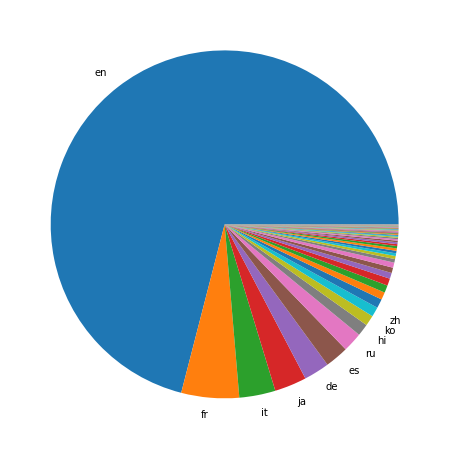

In [13]:
lng_counts = movies['original_language'].value_counts()

top_lng = lng_counts.index.tolist()[:10]
labels = top_lng + [""]*(lng_counts.index.size - 10)
plt.figure(figsize=(8, 8))
plt.pie(lng_counts, labels=labels)

plt.show()

English is the most dominent language in our dataset, while there's also French, Italian, Japanease, German, Spanish, Russian and more.

Let's look at statistics about the release dates and the duration:  

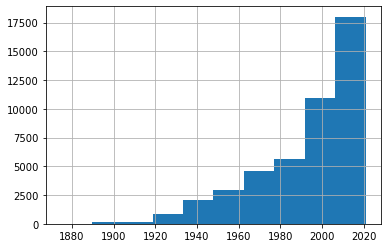

In [14]:
movies['release_date'].hist()
plt.show()

We can see that our dataset is comprised mainly from movies made in recent years, this doesn't necessarily mean that our data is skwed, maybe there really were more movies made in recent years than before.

In [15]:
movies[movies["runtime"] > 400][["title", "runtime", "overview", "keywords", "genres", "original_language", "imdb_id"]].shape

(50, 7)

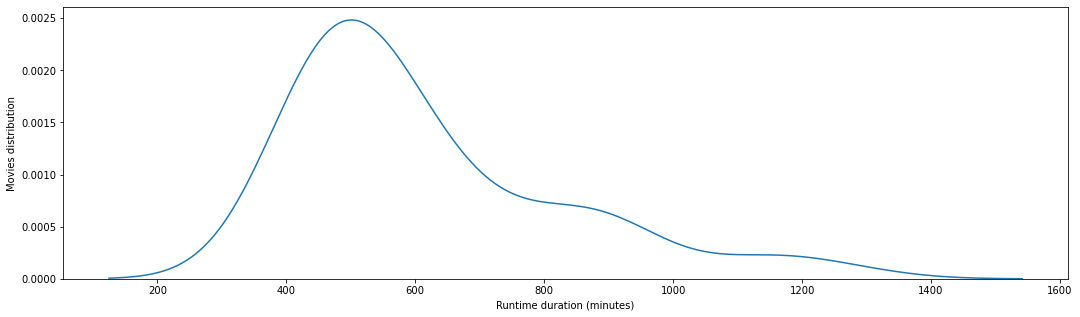

In [16]:
plt.figure(figsize=(18,5))
plt.xlabel("Runtime duration (minutes)")
plt.ylabel("Movies distribution")

# To make the plot more readable we'll remove movies with runtime of over 400 minutes (there's only 25 of them)
sns.kdeplot(data=movies[movies["runtime"] > 400], x="runtime")

plt.show()

The average duration is a little more than an hour and a half, and most movies are between an hour and 2 hours.

Next, let's take a look at the different genres.  
In order to do that we will need to make the genres data usable. Currently the genres of each movie is stored as follows:

In [17]:
movies[movies['title'] == 'Toy Story'][['title', 'genres']]

,title,genres
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."


We'll convert the `genres` field to a simple list of values, and we'll do the same for `keywords`.

For `crew` we will only save the director and for `cast` we will take the top 5 actors - which will be useful when building recommendations models.

In [18]:
movies["genres"] = movies["genres"].apply(lambda value: [x["name"] for x in eval(value)])
movies["keywords"] = movies["keywords"].apply(lambda value: [x["name"] for x in eval(value)])

In [19]:
def get_top_5_actors_names(cast):
    top_actors = eval(cast)[:5]
    return [actor["name"] for actor in top_actors]

movies["top_actors"] = movies["cast"].apply(lambda cast: get_top_5_actors_names(cast))
movies.drop(columns=["cast"], inplace=True)

In [20]:
def get_director_name(crew):
    for crew_member in eval(crew):
        if crew_member["job"] == "Director":
            return crew_member["name"]
movies["director"] = movies["crew"].apply(lambda crew: get_director_name(crew))
movies.drop(columns=["crew"], inplace=True)

To make it simpler to plot different aspects of movies' geners, we'll create a new `DataFrame` that will have a duplicate of each movie per its genre:

In [21]:
movies_genres = movies.explode('genres').rename(columns={'genres': 'genre'})

For example, for the movie "Toy Story" the `movies_genres` `DataFrame` will store the genres as follows:

In [22]:
movies_genres[movies_genres['title'] == 'Toy Story'][['title', 'genre']]

,title,genre
0,Toy Story,Animation
0,Toy Story,Comedy
0,Toy Story,Family


We have the following genres:

In [23]:
genres = movies_genres.groupby("genre").size()\
                    .reset_index().rename(columns={0: 'count'})\
                    .sort_values('count', ascending=False).reset_index(drop=True)

genres

,genre,count
0,Drama,20312
1,Comedy,13196
2,Thriller,7640
3,Romance,6746
4,Action,6607
5,Horror,4679
6,Crime,4314
7,Documentary,3937
8,Adventure,3508
9,Science Fiction,3061


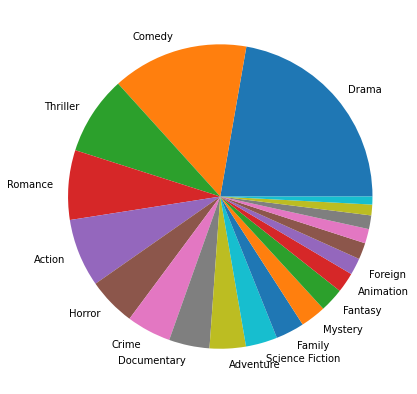

In [24]:
top_genres = genres["genre"].tolist()[:15]

genres_count = movies_genres['genre'].value_counts()
labels = top_genres + [""]*(genres_count.index.size - 15)
plt.figure(figsize=(7, 7))
a = plt.pie(genres_count, labels=labels)

It's clear that most movies produced are categorized as "Drama", "Comedy", "Thriller", "Romance", or "Action".

It will be interesting to see how different movie properties change based on genre. We'll keep it in mind going forward in this notebook.

Next, let's take a look at movies' votes

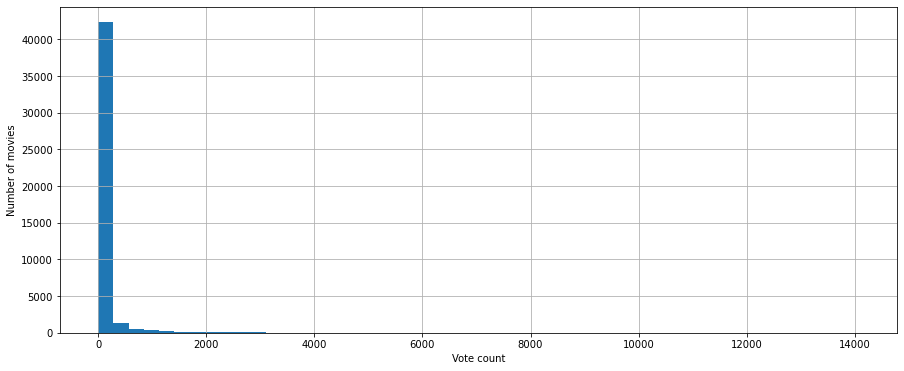

In [25]:
plt.figure(figsize=(15, 6))
movies['vote_count'].hist(bins=50)
plt.xlabel("Vote count")
plt.ylabel("Number of movies")
plt.show()

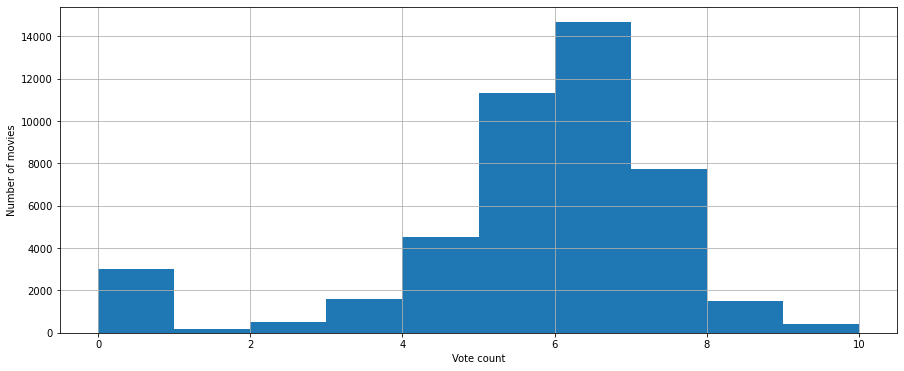

The average movie score is 5.6


In [26]:
plt.figure(figsize=(15, 6))
movies['vote_average'].hist()
plt.xlabel("Vote count")
plt.ylabel("Number of movies")
plt.show()

print(f'The average movie score is {movies["vote_average"].mean():.1f}')

We can deduce most movies have less than 500 ratings, and the average rating of a movie is 5.8

Next we will focus on the users ratings dataset from `movies-dataset/ratings.csv`

In [27]:
ratings = pd.read_csv('movies-dataset/ratings.csv').drop(columns=['timestamp'])
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [28]:
ratings.shape

(26024289, 3)

In [29]:
ratings.value_counts('userId').describe()

count    270896.000000
mean         96.067454
std         205.719606
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max       18276.000000
dtype: float64

We have 26,024,289 ratings from 270,896 users with an average number of movies rated by a user to be 96.

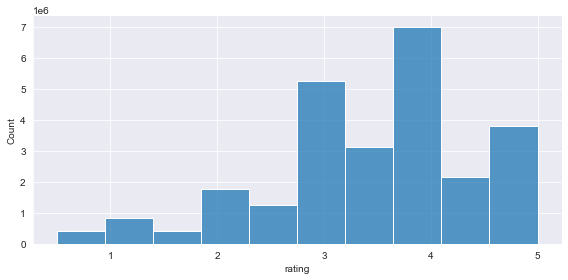

In [30]:
sns.set_style("darkgrid")
sns.displot(ratings, x="rating", bins=10, height=4, aspect=2)
plt.show()

Let's look at the most rated movies (by count) and the top rated movies (by score)

In [31]:
most_rated_movies = ratings.groupby('movieId').size()\
    .reset_index().rename(columns={0: 'count'})\
    .sort_values('count', ascending=False).reset_index(drop=True)
top_rated_movies = ratings.groupby('movieId').mean()\
    .drop(columns='userId').reset_index()\
    .sort_values('rating', ascending=False)\
    .reset_index(drop=True)
# m=movies.merge(links, left_on='id', right_on='tmdbId')

# movies = movies_metadata.merge(credits, on='id').merge(keywords, on='id')


Trying to merge the `movies` DataFrame with the `most_rated_movies` DataFrame shows a problem:

In [32]:
most_rated_movies.head(10).merge(movies, left_on='movieId', right_on='id')[["movieId", "title"]]

,movieId,title
0,318,The Million Dollar Hotel
1,296,Terminator 3: Rise of the Machines
2,593,Solaris
3,260,The 39 Steps
4,480,Monsoon Wedding
5,527,Once Were Warriors
6,110,Three Colors: Red


I don't recognize those movies, and seeing as those should be the movies with the most ratings this is unlikely.

Reading from the Kaggle project's description, I understand that the `id` column in `movies` DataFrame is probably the TMDB ID (the ID from the _The Movies Data Base_) where most info was scraped from and the `movieId` column in `ratings` is an ID from _MovieLens_ database, so let's fix that and make the `ratings` DataFrame have an `id` column like `movies`.

To do that we'll need another CSV that contains all the connections between the different IDs, the `links.csv` file

In [33]:
links = pd.read_csv('movies-dataset/links.csv').dropna().astype({"tmdbId": int})

In [34]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [35]:
ratings = ratings.merge(links, on='movieId')[["userId", "tmdbId", "rating"]].rename(columns={"tmdbId": "movieId"})

Now, let's try to see the most rated movies' title

In [36]:
most_rated_movies = ratings.groupby('movieId').size()\
    .reset_index().rename(columns={0: 'count'})\
    .sort_values('count', ascending=False).reset_index(drop=True)
top_rated_movies = ratings.groupby('movieId').mean()\
    .drop(columns='userId').reset_index()\
    .sort_values('rating', ascending=False)\
    .reset_index(drop=True)

In [37]:
most_rated_movies.head(10).merge(movies, left_on='movieId', right_on='id')[["id", "title", "count"]]

,id,title,count
0,13,Forrest Gump,91921
1,278,The Shawshank Redemption,91082
2,680,Pulp Fiction,87901
3,274,The Silence of the Lambs,84078
4,603,The Matrix,77960
5,11,Star Wars,77045
6,329,Jurassic Park,74355
7,424,Schindler's List,67662
8,197,Braveheart,66512
9,862,Toy Story,66008


In [38]:
top_rated_movies.head(10).merge(movies, left_on='movieId', right_on='id')[["id", "title", "rating"]]

,id,title,rating
0,258113,Assepoester: Een Modern Sprookje,5.0
1,54583,Hollywood North,5.0
2,262831,Banana Paradise,5.0
3,262522,Poison,5.0
4,159550,The Last Brickmaker in America,5.0
5,69161,Heroes Shed No Tears,5.0
6,46121,The Capture of the Green River Killer,5.0
7,159763,A Nanny's Revenge,5.0
8,159898,The Boxing Cats (Prof. Welton's),5.0
9,159910,Hadj Cheriff,5.0


This list of movies makes more sense!

In [39]:
# TODO: Take more EDA ideas from https://www.kaggle.com/code/rounakbanik/the-story-of-film/notebook

## Description Words

For each movie we the `keywords` and the `overview` columns that contain actual text that can help us understand the movie better than just very general labels like `genres`.

In [40]:
keywords_count_by_movie = movies["keywords"].apply(lambda keywords: len(keywords)).sort_values().to_frame()

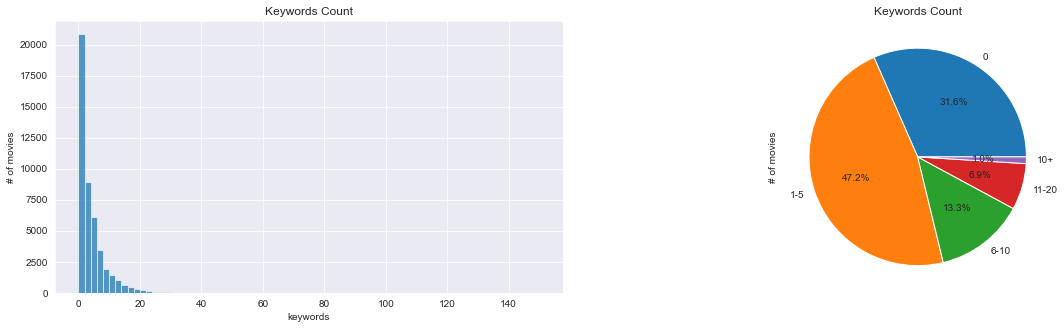

In [41]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
sns.histplot(data=keywords_count_by_movie, x="keywords", binwidth=2, ax=ax1)
ax1.title.set_text("Keywords Count")
ax1.set_ylabel("# of movies")

ax2 = plt.subplot(122)
keywords_bins_cut = pd.cut(keywords_count_by_movie["keywords"], bins=[-1, 0, 5, 10, 20, 200], labels=["0", "1-5", "6-10", "11-20", "10+"])
keywords_bins = keywords_bins_cut.to_frame().groupby('keywords').size()
keywords_bins.plot.pie(autopct="%1.1f%%", ax=ax2)
ax2.title.set_text("Keywords Count")
ax2.set_ylabel('# of movies')

plt.show()

So for most movies we don't have any keywords at all, and for those that do have almost all have less than 10 keywords describing them.

Most common keywords:

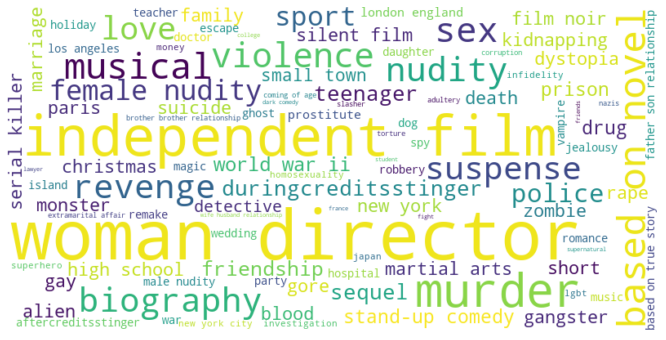

In [42]:
from wordcloud import WordCloud

keywords_freq = movies["keywords"].explode().dropna().value_counts()

wc = WordCloud(background_color="white", max_words=100, width=800, height=400)
wc.generate_from_frequencies(keywords_freq.to_dict())

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

plt.show()

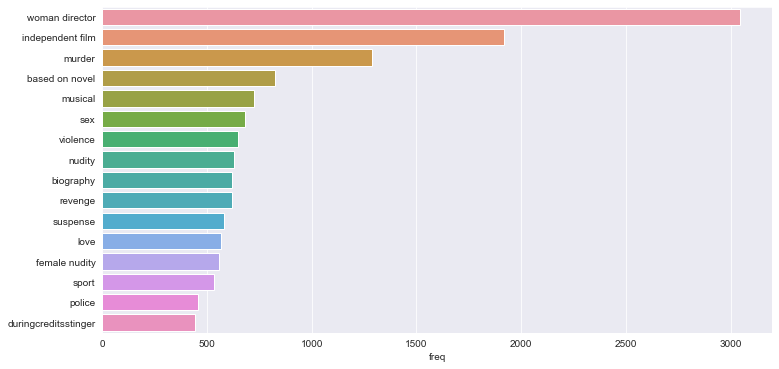

In [43]:
most_freq_keywords = keywords_freq.to_frame("freq").sort_values(by="freq", ascending=False).head(16)

plt.figure(figsize=(12, 6))
sns.barplot(data=most_freq_keywords, x="freq", y=most_freq_keywords.index, orient="h")
plt.show()

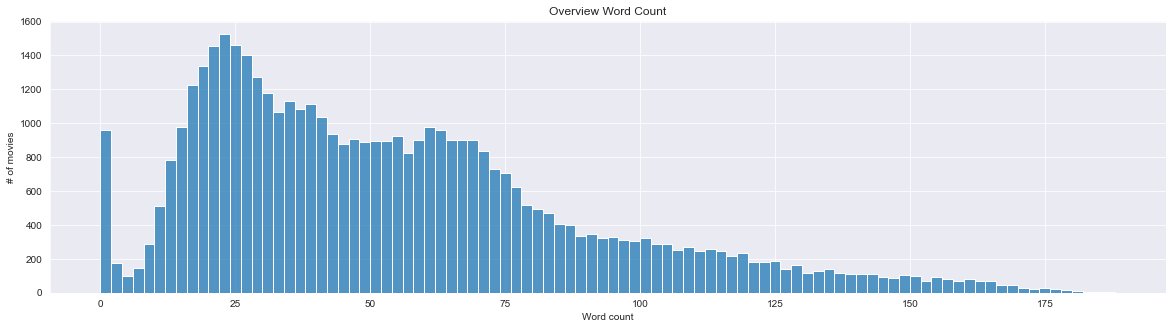

In [44]:
overview_word_count = movies["overview"].fillna("")\
    .apply(lambda overview: 0 if len(overview) == 0 else len(overview.split(" ")))\
    .to_frame()\
    .rename(columns={'overview': 'word_count'})
overview_word_count
plt.figure(figsize=(20, 5))

sns.histplot(data=overview_word_count, x="word_count", binwidth=2)
plt.title("Overview Word Count")
plt.ylabel("# of movies")
plt.xlabel("Word count")

plt.show()

## Finding Correlations

It can be interesting to try and find correlation between some parameters to the movie's vote average.  

Let's start by investigating the genre

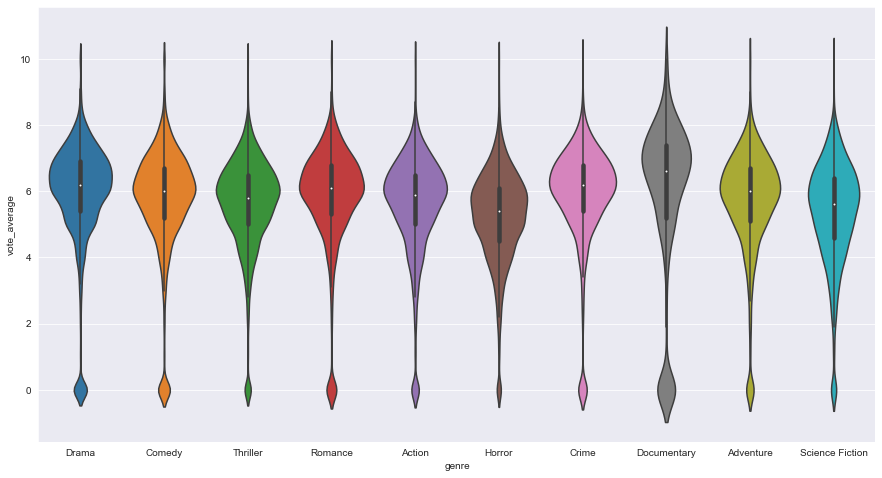

In [45]:
movies_in_top_genres = movies_genres[movies_genres['genre'].isin(top_genres[:10])]
plt.figure(figsize=(15,8))
sns.violinplot(x="genre", y="vote_average", data=movies_in_top_genres, order=top_genres[:10])
plt.show()

We can see that the average rating and its variance is consistent within the top 10 genres, with "Documentary" and "Science Fiction" being the only exception, they are more contreversial in comparsing to the rest of the genres.

# Building a Recommendation System

## Recommendation Systems Types

A recommendation system is a type of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.  
There are 2 common types of recommendations systems _content based_ and _collaborative based_.

A __content based__ recommendations system uses the description of items and the user's past to recommend items the user might like. Those kind of systems rely on a well tagged dataset of items and the user's preferences

A __collaborative based__ recommendations system doesn't use data on the items at all, rather relying on finding similar interests between different users.  
This is based on the assumption that people who agreed in the past will agree in the future, and that they will like simimlar kinds of items as they liked in the past.The importance of analyzing users' preferences is key, with data collection being collected explicitly (likes, dislikes, ratings) and implicitly (viewing times).

Most recommendations systems feature a hybrid approch of those two methods.

I want to look at the problem from a number of different point of views, so I'll try to create multiple recommendation systems that each function in a different way, and in the end combine all of them.

## First Try - A Content Based Recommendation System

For a content based recommendation system, we need to find similarities between movies based on properties that **we** think are key properties.

We will focus on:
* Genres
* Original language
* Keywords
* Overview
* Crew
    * Director
* Cast
    * Top 5 actors

The properties __genres, original language, keywords, crew and cast__ are unique identifiers, our theory is that movies that contain the same such properties will be a good fit for our users.  
But the __overview__ property is different in that it's a text based description of the movie, so there won't be two movies with the same __overview__, so for the __overview__ propery will take a different approach than the other properties.

### Genres, Original language, Keywords, Director and Top Actors

Let's take a look at these properties, and remove movies that's missing any of these properties:

In [46]:
properties_columns = ["original_language", "genres", "director", "top_actors", "keywords"]
movies[["title", *properties_columns]].head()

,title,original_language,genres,director,top_actors,keywords
0,Toy Story,en,"[Animation, Comedy, Family]",John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva..."
1,Jumanji,en,"[Adventure, Fantasy, Family]",Joe Johnston,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'..."
2,Grumpier Old Men,en,"[Romance, Comedy]",Howard Deutch,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o..."
3,Waiting to Exhale,en,"[Comedy, Drama, Romance]",Forest Whitaker,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin..."
4,Father of the Bride Part II,en,[Comedy],Charles Shyer,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug..."


In [47]:
filtered_movies = movies[movies.apply(lambda row: len(row['keywords']) >= 3 and len(row['top_actors']) >= 1, axis=1)]\
    .dropna(subset=["director"])\
    .fillna({"original_language": ""})

print(f'We can recommend {filtered_movies.shape[0]} movies')

We can recommend 19574 movies


We will use the **Bag of Words** technique to vectorize each movie, which means we need to represent each movie using one sentence.

Columns `keywords` and `top_actors` that cotains lists of strings might have strings with multiple words, for example, the `top_actors` column might contain `["Tom Hanks", "George Kelly", "Tom Holloway"]`, so the final string representing the movie will be `".. Tom Hanks George Kelly Tom Holloway .."`, and so we won't be able to differentiate between Tom Hanks and Tom Holloway, to fix this we'll remove spaces between words in the same string.

In [48]:
def build_plain_properties_corpus(movies_df):
    corpus = []

    for _, m in movies_df.iterrows():
        movie_prop = ""
        for property_column in properties_columns:
            value = m[property_column]
            if isinstance(value, list):
                # We'll remove all inner spaces to differentiate between i.e. "Tom Holloway" and "Tom Hanks"
                no_spaces_value = [item.replace(' ', '') for item in value]
                movie_prop += " ".join(no_spaces_value)
            else:
                movie_prop += value.replace(' ', '')
            movie_prop += " "
        corpus.append(movie_prop)

    return corpus

For example, for the movie "Forrest Gump":

In [49]:
movies[movies['title'] == 'Forrest Gump'][["title", *properties_columns]]

,title,original_language,genres,director,top_actors,keywords
351,Forrest Gump,en,"[Comedy, Drama, Romance]",Robert Zemeckis,"[Tom Hanks, Robin Wright, Gary Sinise, Mykelti...","[vietnam veteran, hippie, mentally disabled, r..."


We'll create the following string that represents it:

```
en Comedy Drama Romance RobertZemeckis TomHanks RobinWright GarySinise MykeltiWilliamson SallyField vietnamveteran hippie mentallydisabled running basedonnovel vietnam vietnamwar friendship love familyrelationships bully mothersonrelationship military hugging shrimping woundedsoldier flashback parkbench amputee
```

**Vectorization Method**

The strings we're dealing with don't have the characteristics of actual documents, they don't have semantic meaning and they don't contain stop words like "the", "and" and so on, these strings are just text representation of the movies' properties, and as such choosing a simple method of feature extraction such as `HashingVectorizer` is fitting.

In [50]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import linear_kernel

class PlainPropertiesRecommender:
    def __init__(self, movies_df):
        self.movies_df = movies_df
        self._corpus = build_plain_properties_corpus(self.movies_df)
        transformer = HashingVectorizer(stop_words="english", ngram_range=(1, 2))
        self._tfidf_matrix = transformer.fit_transform(self._corpus)

    def recommend(self, movie_title: str, top_n: int = 5):
        # We have to reindex the movies DataFrame because later we use indexing into the matrix
        reindexed_movies = self.movies_df.reset_index(drop=True)

        ind = reindexed_movies[reindexed_movies["title"] == movie_title].index.item()

        # Instead of building a matrix of similarities between all movies, we just compare
        # the movie we're interested in with all the movies - this way we don't need too much memory
        sim = linear_kernel(np.asarray(self._tfidf_matrix[ind].todense()), self._tfidf_matrix)

        m_sim = sim[0]

        top_sims = m_sim.argsort()[-1 - top_n:-1]
        top_sims = np.flip(top_sims)

        return reindexed_movies.iloc[top_sims]

plain_props_recommender = PlainPropertiesRecommender(filtered_movies)

Now let's see some results!

In [51]:
display(plain_props_recommender.recommend('Pulp Fiction')[["id", "title", *properties_columns]])
display(plain_props_recommender.recommend('Avengers: Age of Ultron')[["id", "title", *properties_columns]])
display(plain_props_recommender.recommend('Shutter Island')[["id", "title", *properties_columns]])

,id,title,original_language,genres,director,top_actors,keywords
3944,1613,The 51st State,en,"[Thriller, Action, Comedy, Crime]",Ronny Yu,"[Samuel L. Jackson, Robert Carlyle, Emily Mort...","[chemical, laxative, skinheads]"
8534,8285,The Spirit,en,"[Action, Comedy, Thriller, Crime, Science Fict...",Frank Miller,"[Gabriel Macht, Scarlett Johansson, Samuel L. ...","[secret identity, robber, mask, frog, based on..."
4473,9257,S.W.A.T.,en,"[Action, Thriller, Crime]",Clark Johnson,"[Samuel L. Jackson, Colin Farrell, Michelle Ro...","[liberation, transport of prisoners, special u..."
4289,10782,Basic,en,"[Action, Drama, Mystery, Thriller, Crime]",John McTiernan,"[John Travolta, Connie Nielsen, Samuel L. Jack...","[drug addiction, military court, panama, milit..."
7201,9959,Freedomland,en,"[Drama, Thriller, Crime, Mystery]",Joe Roth,"[Samuel L. Jackson, Julianne Moore, Edie Falco...","[black people, new jersey, lie, psychological ..."


,id,title,original_language,genres,director,top_actors,keywords
10760,24428,The Avengers,en,"[Science Fiction, Action, Adventure]",Joss Whedon,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...","[new york, shield, marvel comic, superhero, ba..."
14148,271110,Captain America: Civil War,en,"[Adventure, Action, Science Fiction]",Anthony Russo,"[Chris Evans, Robert Downey Jr., Scarlett Joha...","[civil war, war, marvel comic, sequel, superhe..."
12798,100402,Captain America: The Winter Soldier,en,"[Action, Adventure, Science Fiction]",Anthony Russo,"[Chris Evans, Samuel L. Jackson, Scarlett Joha...","[washington d.c., future, shield, marvel comic..."
14146,284053,Thor: Ragnarok,en,"[Action, Adventure, Fantasy, Science Fiction]",Taika Waititi,"[Chris Hemsworth, Tom Hiddleston, Cate Blanche...","[marvel comic, sequel, superhero, based on com..."
14143,102899,Ant-Man,en,"[Science Fiction, Action, Adventure]",Peyton Reed,"[Paul Rudd, Michael Douglas, Evangeline Lilly,...","[marvel comic, superhero, based on comic, afte..."


,id,title,original_language,genres,director,top_actors,keywords
5601,4176,Murder on the Orient Express,en,"[Drama, Thriller, Mystery]",Sidney Lumet,"[Albert Finney, Lauren Bacall, Martin Balsam, ...","[detective, repayment, orient express, investi..."
9984,1782,Afterwards,en,"[Drama, Thriller, Mystery]",Gilles Bourdos,"[John Malkovich, Romain Duris, Evangeline Lill...","[prophecy, lawyer, doctor]"
5651,9391,Enduring Love,en,"[Drama, Thriller, Mystery]",Roger Michell,"[Daniel Craig, Rhys Ifans, Samantha Morton, Bi...","[picnic, hot air balloon, rescue]"
10848,69668,Dream House,en,"[Drama, Thriller, Mystery]",Jim Sheridan,"[Daniel Craig, Naomi Watts, Rachel Weisz, Mart...","[house fire, extension ladder, last day on job]"
8952,49767,Fade to Black,en,"[Drama, Thriller, Mystery]",Oliver Parker,"[Danny Huston, Diego Luna, Paz Vega, Christoph...","[film making, historical figure, orson welles]"


### Movies' Overview

The __overview__ column contains a short description of the movie plot, and can help us better identify similarities between movies.  

We can't extract features from the __overview__ column the same as we did with the __genres, original language, keywords, crew and cast__ columns, it requires a different approach.  
The problem is that it's a real text, meaning that similar overviews might contain **different words**, but have a **similar meaning**. We will try a number of techniques of finding similar overviews.

The first technique is TF-IDF.

#### TF-IDF

Stands for **term-frequency inverse document-frequency**.  
In this vectorization technique, we treat the __overview__ as a Bag of Words, but instead of just counting the the number of appearences of each word in each document (document here is an __overview__), we also take into account the number of documents the word appears in.  
In general:
* The more a word appears in a document -> the more important it is
* The more documents a word appears in -> the less important it is

For example, for the __overview__ of the movie __Jaws__:
> An insatiable great white shark terrorizes the townspeople of Amity Island, The police chief, an oceanographer and a grizzled shark hunter seek to destroy the bloodthirsty beast.

The word "shark" is less common than "police" in movies' overviews, so it has higher importance.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

class TfidfRecommender:
    def __init__(self, movies_df):
        self.movies_df = movies_df
        self._corpus = self._build_corpus()
        self._transformer = transformer = TfidfVectorizer(stop_words="english")
        self._tfidf_matrix = transformer.fit_transform(self._corpus)

    def _build_corpus(self):
        return self.movies_df['overview'].fillna("").tolist()

    def recommend(self, movie_title: str, top_n: int = 5):
        # We have to reindex the movies DataFrame because later we use indexing into the matrix
        reindexed_movies = self.movies_df.reset_index(drop=True)

        ind = reindexed_movies[reindexed_movies["title"] == movie_title].index.item()

        # Instead of building a matrix of similarities between all movies, we just compare
        # the movie we're interested in with all the movies - this way we don't need too much memory
        sim = linear_kernel(np.asarray(self._tfidf_matrix[ind].todense()), self._tfidf_matrix)

        m_sim = sim[0]

        top_sims = m_sim.argsort()[-1 - top_n:-1]
        top_sims = np.flip(top_sims)

        return reindexed_movies.iloc[top_sims]

tfidf_recommender = TfidfRecommender(movies)

In [239]:
with pd.option_context('display.max_colwidth', -1):
    display(tfidf_recommender.recommend('Pulp Fiction', top_n=5)[["title", "overview", "genres"]])
    display(tfidf_recommender.recommend('Avengers: Age of Ultron', top_n=5)[["title", "overview", "genres"]])
    display(tfidf_recommender.recommend('Shutter Island', top_n=5)[["title", "overview", "genres"]])

,title,overview,genres
885,The Sting,Set in the 1930's this intricate caper deals with an ambitious small-time crook and a veteran con man who seek revenge on a vicious crime lord who murdered one of their gang.,"[Comedy, Crime, Drama]"
9417,The First Day of the Rest of Your Life,A sprawling drama centered on five key days in a family's life.,[Drama]
491,Moll Flanders,"The daughter of a thief, young Moll is placed in the care of a nunnery after the execution of her mother. However, the actions of an abusive priest lead Moll to rebel as a teenager, escaping to the dangerous streets of London. Further misfortunes drive her to accept a job as a prostitute from the conniving Mrs. Allworthy. It is there that Moll first meets Hibble, who is working as Allworthy's servant but takes a special interest in the young woman's well-being. With his help, she retains hope for the future, ultimately falling in love with an unconventional artist who promises the possibility of romantic happiness.","[Drama, Romance]"
2634,Prizzi's Honor,"A professional hit man and hit woman fall in love, only to discover that they have each been hired to kill the other.","[Romance, Comedy, Crime, Drama]"
15509,Baby Face Nelson,Famed Depression-era gangster “Baby Face Nelson” (Mickey Rooney) robs and kills while accompanied by his beautiful moll (Carolyn Jones).,"[Crime, Drama]"


,title,overview,genres
10760,The Avengers,"When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!","[Science Fiction, Action, Adventure]"
14148,Captain America: Civil War,"Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarizes opinion amongst the Avengers, causing two factions to side with Iron Man or Captain America, which causes an epic battle between former allies.","[Adventure, Action, Science Fiction]"
9593,Iron Man 2,"With the world now aware of his dual life as the armored superhero Iron Man, billionaire inventor Tony Stark faces pressure from the government, the press and the public to share his technology with the military. Unwilling to let go of his invention, Stark, with Pepper Potts and James 'Rhodey' Rhodes at his side, must forge new alliances – and confront powerful enemies.","[Adventure, Action, Science Fiction]"
15448,A Deadly Adoption,"Things go awry when an author and his wife welcome a pregnant woman into their home, with plans to adopt her baby.","[Drama, Thriller]"
8337,Iron Man,"After being held captive in an Afghan cave, billionaire engineer Tony Stark creates a unique weaponized suit of armor to fight evil.","[Action, Science Fiction, Adventure]"


,title,overview,genres
10584,Education for Death,A propaganda film during World War II about a boy who grows up to become a Nazi soldier.,[Animation]
12234,Act of Love,An American soldier romances a beautiful Parisian during the final days of World War II.,"[Drama, War, Romance]"
18129,The Scarf,"John Ireland stars in this thriller as a man who breaks out of an asylum for the criminally insane, where he has been committed for strangling a girl with a scarf.","[Drama, Mystery, Thriller]"
10319,Closing the Ring,"During the 1940s, a group of young men go off to war, leaving behind Ethel Ann (Mischa Barton), who is in love with one of them, Teddy. In modern-day Belfast, a man named Jimmy (Martin McCann) endeavors to return a ring found in the wreckage of a crashed plane. He travels to Michigan, where the grown Ethel Ann (Shirley MacLaine), who married another man after Teddy was killed in battle, now lives. Ethel Ann must decide whether to go with Jimmy to meet the soldier who last saw Teddy alive.","[Drama, Romance]"
14391,The Conspirators,A guerilla leader falls in love with a mysterious woman in World War II Lisbon.,"[Drama, History, Thriller]"


**Analyzing the Results**

Let's dig deeper into the results we got with "Shutter Island", this is its overview:
> World War II soldier-turned-U.S. Marshal Teddy Daniels investigates the disappearance of a patient from a hospital for the criminally insane, but his efforts are compromised by his troubling visions and also by a mysterious doctor.

The overviews of the movies "Education for Death", "Act of Love" and "The Conspirators" are only similar to the overview of Shutter Island's in the words "World War II", this is good, but are those really the _most similar_ movies to Shutter Island?  
As humans we understand that movies with the words __investigation, disappearance, patient, hospital, criminal, insane, mysterious, doctor__ are likely to be better recommendations than those we got from the TF-IDF algorithm

In [102]:
movies[movies["title"] == "Shutter Island"].iloc[0]["overview"]

'World War II soldier-turned-U.S. Marshal Teddy Daniels investigates the disappearance of a patient from a hospital for the criminally insane, but his efforts are compromised by his troubling visions and also by a mysterious doctor.'

In [ ]:
from nltk.tokenize import word_tokenize
import gensim

with pd.option_context('display.max_colwidth', -1):
    display(movies[movies["title"].isin(["Inception", "Fight Club", "Monsters, Inc."])][["title", "overview", "genres"]])

movies_comparison = movies[movies["title"].isin(["Inception", "Fight Club", "Monsters, Inc."])][["title", "overview"]]
movies_words = {
    row['title']: set(gensim.utils.simple_preprocess(row['overview'])) for _, row in movies_comparison.iterrows()
}
f_i_inter = movies_words['Inception'].intersection(movies_words['Fight Club'])
f_m_inter = movies_words['Fight Club'].intersection(movies_words['Monsters, Inc.'])

print(f"There's {len(f_i_inter)} words in common between Fight Club and Inception: {f_i_inter}")
print(f"There's {len(f_m_inter)} words in common between Fight Club and Monsters, Inc.: {f_m_inter}")

,title,overview,genres
2854,Fight Club,"A ticking-time-bomb insomniac and a slippery soap salesman channel primal male aggression into a shocking new form of therapy. Their concept catches on, with underground ""fight clubs"" forming in every town, until an eccentric gets in the way and ignites an out-of-control spiral toward oblivion.",[Drama]
4773,"Monsters, Inc.","James Sullivan and Mike Wazowski are monsters, they earn their living scaring children and are the best in the business... even though they're more afraid of the children than they are of them. When a child accidentally enters their world, James and Mike suddenly find that kids are not to be afraid of and they uncover a conspiracy that could threaten all children across the world.","[Animation, Comedy, Family]"
15545,Inception,"Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.","[Action, Thriller, Science Fiction, Mystery, Adventure]"


There's 3 words in common between Fight Club and Inception: {'of', 'the', 'into'}
There's 5 words in common between Fight Club and Monsters, Inc.: {'the', 'and', 'of', 'in', 'their'}


#### Doc2Vec

TF-IDF is a good technique, but it's naive, it only compares words by equality and doesn't know anymore than that. We want a model that can compare words not just in a binary way, for example to know that a "car" and a "minivan" is closer in meaning than "car" and "fridge".

In 2013 a technique named Word2Vec was published, allowing to create a model that can find synonymous words and indicate **semantic similarity** between words.  
The model converts words into vectors such that the consine similarity between those vectors indicate that semantic similarity, we can use that property to compare words in a more meaningful way.

In [65]:
wv.similar_by_word("subconscious")

[('subconscious_mind', 0.7451375126838684),
 ('unconsciously', 0.6809317469596863),
 ('subconsciously', 0.6625826358795166),
 ('subliminal', 0.6212795972824097),
 ('subliminally', 0.6045939922332764),
 ('subconsciousness', 0.5970091223716736),
 ('preconscious', 0.5798879265785217),
 ('subconcious', 0.5776683688163757),
 ('primal', 0.5670777559280396),
 ('instinctual', 0.5540027618408203)]

In [75]:
wv.similarity('fire', 'water')

0.22717673

In [73]:
wv.similarity('body', 'mind')

0.24243814

In [310]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [311]:
import gensim

def read_corpus():
    for index, row in movies[~movies["overview"].isna()].iterrows():
        tokens = gensim.utils.simple_preprocess(row['overview'])
        yield gensim.models.doc2vec.TaggedDocument(tokens, [str(index)])

In [312]:
train_corpus = list(read_corpus())

In [313]:
import os

if not os.path.exists(".cache/overviews.model"):
    model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=4, epochs=30)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    os.makedirs(".cache", exist_ok=True)
    model.save(".cache/overviews.model")
else:
    model = gensim.models.doc2vec.Doc2Vec.load(".cache/overviews.model")

2022-07-14 11:46:47,355 : INFO : loading Doc2Vec object from .cache/overviews.model
2022-07-14 11:46:47,453 : INFO : loading dv recursively from .cache/overviews.model.dv.* with mmap=None
2022-07-14 11:46:47,455 : INFO : loading wv recursively from .cache/overviews.model.wv.* with mmap=None
2022-07-14 11:46:47,458 : INFO : setting ignored attribute cum_table to None
2022-07-14 11:46:50,376 : INFO : Doc2Vec lifecycle event {'fname': '.cache/overviews.model', 'datetime': '2022-07-14T11:46:50.376614', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [314]:
def find_most_similar(movie_title: str):
    overview = movies[movies['title'] == movie_title].iloc[0]['overview']
    overview_toks = gensim.utils.simple_preprocess(overview)

    overview_vec = model.infer_vector(overview_toks)
    similarities = model.dv.most_similar([overview_vec], topn=len(model.dv))
    for tag, similarity in similarities:
        yield movies.loc[int(tag)]['title'], similarity

# find_most_similar("Toy Story")

In [315]:
def compare(movie1, movie2):
    overview = movies[movies['title'] == movie1].iloc[0]['overview']
    overview2 = movies[movies['title'] == movie2].iloc[0]['overview']

    overview_toks = gensim.utils.simple_preprocess(overview)
    overview2_toks = gensim.utils.simple_preprocess(overview2)

    overview_vec = model.infer_vector(overview_toks)
    overview2_vec = model.infer_vector(overview2_toks)

    # model.dv.cosine_similarities(overview_toks, overview2_toks)
    similarity_score = model.dv.cosine_similarities(overview_vec, [overview2_vec]).item()

    print(f'{movie1} <> {movie2} - {similarity_score:.4f}')

compare('Toy Story', 'Toy Story 2')
compare('Toy Story', 'Toy Story 2')
compare('Toy Story', 'Finding Nemo')
compare('Shutter Island', 'Finding Nemo')
compare('Toy Story', 'Shutter Island')
compare('Fight Club', 'Shutter Island')

Toy Story <> Toy Story 2 - 0.4700
Toy Story <> Toy Story 2 - 0.5024
Toy Story <> Finding Nemo - 0.1924
Shutter Island <> Finding Nemo - 0.3368
Toy Story <> Shutter Island - 0.1766
Fight Club <> Shutter Island - 0.0895


In [316]:
for title in ['Toy Story', 'Toy Story 2', 'Shutter Island', 'Finding Nemo', 'Pulp Fiction']:
    print(f'# {title}')
    print(movies[movies["title"] == title].iloc[0]["overview"])
    print()

# Toy Story
Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.

# Toy Story 2
Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, owner of Al's Toy Barn kidnaps Woody. Andy's toys mount a daring rescue mission, Buzz Lightyear meets his match and Woody has to decide where he and his heart truly belong.

# Shutter Island
World War II soldier-turned-U.S. Marshal Teddy Daniels investigates the disappearance of a patient from a hospital for the criminally insane, but his efforts are compromised by his troubling visions and also by a mysterious doctor.

# Finding Nemo
Nemo, an adventurous young clownfish, is unexpectedly taken from his Great Barri

In [317]:
def find_most_similar_g_tf(movie_title: str):
    sim_df = movies.copy()

    ind = sim_df[sim_df["title"] == movie_title].index.item()
    sim_matrix = linear_kernel(hashing_matrix[ind:ind + 1, :].todense(), hashing_matrix)

    m_sim = sim_matrix[0]

    sim_df["tfidf_similarity"] = m_sim

    overview = movies[movies['title'] == movie_title].iloc[0]['overview']
    overview_toks = gensim.utils.simple_preprocess(overview)
    overview_vec = model.infer_vector(overview_toks)
    
    tag_and_similarities = model.dv.most_similar([overview_vec], topn=len(model.dv))
    d2v_similarities = {int(tag): similarity for tag, similarity in tag_and_similarities}
    sim_df["d2v_similarity"] = pd.Series(data=d2v_similarities)
    sim_df["d2v_similarity"] = sim_df["d2v_similarity"].fillna(0)

    sim_df["sim_average"] = sim_df.apply(lambda row: (row["d2v_similarity"] + row["tfidf_similarity"]) / 2 ,axis=1)
    
    return sim_df.sort_values(by=['sim_average'], ascending=False).head(10)

find_most_similar_g_tf("Toy Story")[["title", "overview", "sim_average", "tfidf_similarity", "d2v_similarity"]]

/Users/adi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



,title,overview,sim_average,tfidf_similarity,d2v_similarity
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",0.959129,1.000000,0.918257
3008,Toy Story 2,"Andy heads off to Cowboy Camp, leaving his toy...",0.288265,0.415067,0.161463
2250,A Bug's Life,"On behalf of ""oppressed bugs everywhere,"" an i...",0.284990,0.245523,0.324457
12748,WALL·E,WALL·E is the last robot left on an Earth that...,0.273770,0.218236,0.329304
41428,The Secret Garden,When a spoiled English girl living in 19th cen...,0.272433,0.027778,0.517088
15413,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",0.251022,0.268752,0.233293
3024,The Bonfire of the Vanities,"After his mistress runs over a young teen, a W...",0.250855,0.035533,0.466176
37,It Takes Two,Identical 9-year-olds from very different back...,0.250328,0.050252,0.450404
27465,Who Was That Lady?,In order to get back into the good graces with...,0.248460,0.030241,0.466679
9164,Thursday,Casey has given up drug dealing for a suburban...,0.237927,0.012270,0.463583


### Word2Vec

In [60]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [322]:
import gensim
from gensim.models.keyedvectors import KeyedVectors
from nltk.tokenize import word_tokenize

wv: KeyedVectors

not_found = set()
def generate_w2v(overview: str):
    tokens = word_tokenize(overview)

    a = np.empty((0, 300), np.float32)
    for token in tokens:
        try:
            a = np.append(a, np.array([wv[token]]), axis=0)
        except KeyError:
            not_found.add(token)

    return np.mean(a, axis=0)

movies["w2v"] = movies["overview"].apply(lambda overview: generate_w2v(overview) if isinstance(overview, str) else np.nan)
print(f'Failed to find {len(not_found)} words')

Failed to find 17335 words


In [323]:
from sklearn.metrics.pairwise import cosine_similarity

def get_w2v(title: str):
    return movies[movies["title"] == title].iloc[0]["w2v"]


def w2v_similarity(title1, title2):
    return cosine_similarity([get_w2v(title1)], [get_w2v(title2)]).item()

for m1, m2 in [
    ("Toy Story", "Toy Story 2"),
    ("Toy Story", "Finding Dory"),
    ("Toy Story", "Finding Nemo"),
    ("Toy Story", "Inside"),
    ("Toy Story", "Shutter Island"),
    ("Fight Club", "Shutter Island"),
    ("Fight Club", "The Truman Show"),
    ("Fight Club", "Requiem for a Dream"),
    ("Fight Club", "Toy Story"),
    ("Fight Club", "Finding Dory"),
]:
    simi_score = w2v_similarity(m1, m2)
    print(f'{m1:<20} <> {m2:<20} - {simi_score:.3f}')

Toy Story            <> Toy Story 2          - 0.853
Toy Story            <> Finding Dory         - 0.704
Toy Story            <> Finding Nemo         - 0.588
Toy Story            <> Inside               - 0.575
Toy Story            <> Shutter Island       - 0.648
Fight Club           <> Shutter Island       - 0.641
Fight Club           <> The Truman Show      - 0.744
Fight Club           <> Requiem for a Dream  - 0.729
Fight Club           <> Toy Story            - 0.657
Fight Club           <> Finding Dory         - 0.620


In [324]:
movies[movies["title"] == "Spider-Man"]["genres"]

5235    [Fantasy, Action]
Name: genres, dtype: object

In [325]:
from sklearn.decomposition import PCA
import plotly.express as px

def get_movies_by_genre(genre: str, topn=10):
    movies_in_genre = movies[movies["genres"].apply(lambda x: genre in x)]
    top = movies_in_genre.sort_values(by=['vote_count', 'vote_average'], ascending=False).head(topn)
    top["genre"] = genre

    return top

def plot_similarities(genres):
    movies_for_plot = pd.concat([get_movies_by_genre(genre, 200) for genre in genres])

    #[["title", "overview", "genres", "vote_count", "vote_average"]]

    pca = PCA(2)
    
    m_2d_vec = pca.fit_transform(movies_for_plot["w2v"].to_list())
    movies_for_plot["w2v_x"] = m_2d_vec[:,0]
    movies_for_plot["w2v_y"] = m_2d_vec[:,1]
    
    fig = px.scatter(movies_for_plot, x="w2v_x", y="w2v_y", color="genre", hover_name="title", hover_data=["genres"], width=1000)
    fig.show()

plot_similarities(["Animation", "Thriller"])
plot_similarities(["Comedy", "History"])

From a very subjective point of view it seems that the model was actually quite successful with "Pulp Fiction" and "Avengers: Age of Ultron", but it's hard for me to judge how good or bad it did with Shutter Island, I don't recognize any of the movies even though I'm an avid fan of the Thriller genre.

TBD Further inspection of the results for "Shutter Island"

Next, we will build the recommendation system for a specific user, based on his ratings

TBD.

### First Try Model Conclusions
We were able to achive, in my opinion, quite good results with minimal effort and a simple model, and I believe more can be done by tweaking the different parameters.

The most appearent problem with the first model the scope of the recommendations is very limited, this is due to the fact that its recommendations are based on movies' similarities. It will be very interesting to compare the results to the collaborative based system and see how different they are.

## Second Try - A Collaborative Based System
This time we will completely ignore the movies' properties and focus solely on finding similarities between different users.

TBD.

TODO: Take images from https://www.youtube.com/watch?v=d7iIb_XVkZs

## Third Try - A Hybrid Approach

According to the winners of Netflix Prize competition in 2007 for the best recommender:
> Predictive accuracy is substantially improved when blending multiple predictors. Our experience is that most efforts should be concentrated in deriving substantially different approaches, rather than refining a single technique. Consequently, our solution is an ensemble of many methods.

In the hybrid approach we'll combine the first and second model.

TBD.

# Further Plans For The Final Project

I think that with more tweaking to the content based model I can get better results, I think that the "keywords" column doesn't give indication for the similarities between movies, and because of the duplication with "crew" and "cast" there's not enough emphasis on the plot.

It would be very interesting to compare the different results of the models and try to analyse the reasons each model behaved the way it did.

Using only my judgment as a way to determine how well a recommender performs is really not good enouhg, I want to dive deeper into different ways to determine how successful a recommendations system is.